In [1]:
from bs4 import BeautifulSoup
import requests
import re
import json

In [2]:
def get_html(url):
    response = requests.get(url)
    return response.text

In [3]:
tvs_url = 'https://rozetka.com.ua/all-tv/c80037/'

In [4]:
from urllib.parse import urlparse

def entity_name(url):
    return urlparse(url).path[1:-1].replace('/','_')

entity_name(tvs_url)

'all-tv_c80037'

In [5]:
from collections import namedtuple

CatalogPage = namedtuple('CatalogPage', 'max_page_num items')

def get_items_page(catalog_url, page_num, log = None):
    page_url = catalog_url if page_num == 0 else catalog_url + 'page={}/'.format(page_num + 1)
    
    soup = BeautifulSoup(get_html(page_url), 'lxml')
    
    title_divs = soup.find_all('div', class_ = 'g-i-tile-i-title clearfix') 

    titles = []
    for div in title_divs:
        a = div.find('a')
        titles.append((a.get("href"), a.text.strip()))
        
    page_items = soup.find_all('li', class_ = 'paginator-catalog-l-i pos-fix')

    max_page_num = [int(item.get('id').replace('page', '').strip()) for item in page_items][-1] 
    
    if not (log is None):
        print('{} {}'.format(catalog_url, page_num), file = log, end = "\n")
        log.flush()
    
    return CatalogPage(max_page_num, titles)

In [6]:
item_url = 'https://rozetka.com.ua/philips_43pus6503_12/p39097504/'

In [7]:
entity_name(item_url)

'philips_43pus6503_12_p39097504'

In [8]:
import time
import json

def scrape_catalog(catalog_url, data_path):
    pages = []
    
    with open(data_path + entity_name(catalog_url) + '.log', 'a') as log:
    
        pages.append(get_items_page(catalog_url, 0, log)) 
        max_page_num = pages[-1].max_page_num
    
        page_num = 1
        while page_num < max_page_num:
            time.sleep(3)
            pages.append(get_items_page(catalog_url, page_num, log))
            page_num += 1
        
    with open(data_path + entity_name(catalog_url) + '.jsonl', 'w') as result:
        json.dump(pages, result)

In [15]:
#scrape_catalog(tvs_url, 'data/')

https://rozetka.com.ua/all-tv/c80037/ 0
https://rozetka.com.ua/all-tv/c80037/ 1
https://rozetka.com.ua/all-tv/c80037/ 2
https://rozetka.com.ua/all-tv/c80037/ 3
https://rozetka.com.ua/all-tv/c80037/ 4
https://rozetka.com.ua/all-tv/c80037/ 5
https://rozetka.com.ua/all-tv/c80037/ 6
https://rozetka.com.ua/all-tv/c80037/ 7
https://rozetka.com.ua/all-tv/c80037/ 8
https://rozetka.com.ua/all-tv/c80037/ 9
https://rozetka.com.ua/all-tv/c80037/ 10
https://rozetka.com.ua/all-tv/c80037/ 11
https://rozetka.com.ua/all-tv/c80037/ 12
https://rozetka.com.ua/all-tv/c80037/ 13
https://rozetka.com.ua/all-tv/c80037/ 14
https://rozetka.com.ua/all-tv/c80037/ 15
https://rozetka.com.ua/all-tv/c80037/ 16
https://rozetka.com.ua/all-tv/c80037/ 17
https://rozetka.com.ua/all-tv/c80037/ 18
https://rozetka.com.ua/all-tv/c80037/ 19
https://rozetka.com.ua/all-tv/c80037/ 20
https://rozetka.com.ua/all-tv/c80037/ 21
https://rozetka.com.ua/all-tv/c80037/ 22
https://rozetka.com.ua/all-tv/c80037/ 23


In [68]:
catalog = []
with open('data/' + entity_name(tvs_url) + '.jsonl') as f_cat:
    catalog = [item for page in json.load(f_cat) for item in page[1]]

catalog[:10]

[['https://rozetka.com.ua/lg_43uk6200plb1/p61571186/',
  'Телевизор LG 43UK6200PLA Оплата частями 24 мес.!'],
 ['https://rozetka.com.ua/hisense_h43a6100_/p40090880/',
  'Телевизор Hisense H43A6100 Smart TV, 4K, 43"'],
 ['https://rozetka.com.ua/samsung_ue58nu7100uxua/p54812544/',
  'Телевизор Samsung UE58NU7100UXUA или Оплата частями на 24 мес.!'],
 ['https://rozetka.com.ua/samsung_ue49n5500auxua/p46780456/',
  'Телевизор Samsung UE49N5500AUXUA Оплата частями на 12 мес.!'],
 ['https://rozetka.com.ua/philips_50pfs5823_12/p52131804/',
  'Телевизор Philips 50PFS5823/12 + 0% Кредит на 10 мес!'],
 ['https://rozetka.com.ua/samsung_qe49q6fnauxua/p46776608/',
  'Телевизор Samsung QE49Q6FNAUXUA Оплата частями на 24 мес.!'],
 ['https://rozetka.com.ua/ergo_le40ct5530ak/p62757784/',
  'Телевизор Ergo LE40CT5530AK + Оплата частями на 10 платежей!'],
 ['https://rozetka.com.ua/panasonic_tx_32dr400/p12689378/',
  'Телевизор Panasonic Viera TX-32DR400 32", HD, T2 Оплата частями на 12 мес. или Сертификат

In [20]:
len(catalog)

758

In [9]:
import re

Comment = namedtuple('Comment', 'text stars replies')


CommentsPage = namedtuple('CommentsPage', 'max_page_num comments')

def get_comments_page(item_url, page_num, log = None):
    comments_url = item_url + 'comments/'
    page_url = comments_url if page_num == 0 else comments_url + 'page={}/'.format(page_num + 1)
    
    soup = BeautifulSoup(get_html(page_url), 'lxml')
    article_divs = soup.find_all('pp-product-comment')
    
    comments = []
    
    for div in article_divs:
        text = [text_div.text.strip().replace(u'\xa0', ' ') \
                for text_div in div.find_all('div', class_ = re.compile('pp-review-text-i.*'))]
    
        replies = [rep_div.text.strip().replace(u'\xa0', ' ') \
                   for rep_div in div.find_all('div', class_ = re.compile('pp-replies-text.*'))]
        
        ratingMeta = div.find('meta', { 'itemprop' :'ratingValue'} )
        stars = 0
        if ratingMeta:
            stars = int(ratingMeta.get('content').strip())
    
        comments.append(Comment(text, stars, replies))
    
    page_items = soup.find_all('li', class_ = re.compile('paginator-l-i.*'))
    
    max_page_num = max([int(item.text.replace('...','0').strip()) for item in page_items]) if page_items else 1
    
    if not (log is None):
        print('{} {}'.format(item_url, page_num), file = log, end = "\n")
        log.flush()
    
    return CommentsPage(max_page_num, comments)

In [10]:
def last_item_url(log_name):
    with open(log_name, 'r') as catalog_log:
        last_uncompleted = ''
        for entry in catalog_log:
            if entry.startswith('Start'):
                last_uncompleted = entry.split('-')[1]

        return last_uncompleted.strip()        
    
def scrape_comments(catalog_url, catalog, data_path):
    log_name = data_path + entity_name(catalog_url) + '-comments.log'
    with open(log_name, 'a') as catalog_log:
        last_url = last_item_url(log_name)
        print("Continue - {}".format(last_url))
        start_index = list(map(lambda i: i[0], catalog)).index(last_url) if last_url else 0
        for item in catalog[start_index:]:
            item_url = item[0]
            print("Start - {}".format(item_url), file = catalog_log, end = '\n')
            catalog_log.flush()
            with open(data_path + entity_name(item_url) + '-comments.log', 'a') as log:
                pages = []
                pages.append(get_comments_page(item_url, 0, log))
                max_page_num = pages[-1].max_page_num
                page_num = 1
                while page_num < max_page_num:
                    time.sleep(3)
                    pages.append(get_comments_page(item_url, page_num, log))
                    page_num += 1

                with open(data_path + entity_name(item_url) + '-comments.jsonl', 'w') as result:
                    json.dump(pages, result)
                    
            print("Complete - {}".format(item_url), file = catalog_log, end = '\n')
            catalog_log.flush()


In [90]:
#scrape_comments(tvs_url, catalog, 'data/')

Continue - https://rozetka.com.ua/toshiba_32s2850ev/p64695862/


In [99]:
!ls -Slh data/*-comments.jsonl | head -n 10

-rw-r--r--  1 serg  staff   746K Apr 23 12:01 data/xiaomi_l32m5_al_p63291772-comments.jsonl
-rw-r--r--  1 serg  staff   650K Apr 23 00:41 data/panasonic_tx_32dr400_p12689378-comments.jsonl
-rw-r--r--  1 serg  staff   621K Apr 23 00:36 data/hisense_h43a6100__p40090880-comments.jsonl
-rw-r--r--  1 serg  staff   596K Apr 23 01:13 data/tcl_43dp600_p58499962-comments.jsonl
-rw-r--r--  1 serg  staff   577K Apr 23 01:11 data/samsung_ue32m5500auxua_p17170562-comments.jsonl
-rw-r--r--  1 serg  staff   543K Apr 23 11:14 data/samsung_ue_22h5600_p699334-comments.jsonl
-rw-r--r--  1 serg  staff   492K Apr 23 11:31 data/sony_kdl40rd453br_p9252786-comments.jsonl
-rw-r--r--  1 serg  staff   428K Apr 23 10:45 data/ergo_le32ct5025ak_p56799339-comments.jsonl
-rw-r--r--  1 serg  staff   406K Apr 23 10:24 data/philips_32pfs4132_12_p17969604-comments.jsonl
-rw-r--r--  1 serg  staff   400K Apr 23 01:08 data/kivi_43up50gu_p53672628-comments.jsonl


In [100]:
!ls data/*-comments.jsonl | wc -l

     758


In [12]:
import glob

def load_comments(data_dir):
    files = glob.glob("{}/*-comments.jsonl".format(data_dir))
    comments = []
    for file in files:
        with open(file) as f:
            comments.extend([Comment(comment[0], comment[1], comment[2]) for page in json.load(f) \
                             for comment in page[1]])
    return comments    

In [21]:
comments = load_comments('data')
len(comments)

21425

In [125]:
comments[:5]

[Comment(text=['Мой первый телевизор со смарт ТВ , даже не смотрел в сторону Самсунгов Лыж и тд.Качество картинки это что-то .Покупал в другой сети с подпиской Мегого максимальный на год . Нету времени перечислять плюсы этой модели и производителя . Берите ,не разочарует .Встроенных динамиков на 20 Вт вполне хватает ,немного неудобно расположены кнопки на пульте.Вай фай по воздуху , все работает как часы.В характеристиках указано 16 гиг ,в параметрах самого телевизора 8 ,но этого вполне достаточно тоже', 'Достоинства:Андроид ,Сони , Картинка ,Звук , и еще много чего', 'Недостатки:Единственное - кнопки пульта расположены неудобно'], stars=5, replies=['То что вы не смотрели в сторону других производителей не означает что их продукция хуже))) У меня к примеру LG 2017 года и я следуя вашим словам не смотрю в сторону Sony не потому что пренебрегаю их продукцией а потому что меня всё устраивает в моём телевизоре.', 'Не смотрел ,так как вся продукция сделана в России', 'А еще другие бренды ст

In [31]:
from langdetect import detect
from tqdm import tqdm_notebook
from langdetect.detector import LangDetectException

def filter_ua_comments(comments):
    ua_comments = []

    for comment in tqdm_notebook(comments):
        try:
            if comment.text and detect(' '.join(comment.text[:10])) == 'uk':
                ua_comments.append(comment)
        except LangDetectException as e: 
            continue
    return ua_comments

In [32]:
ua_comments = filter_ua_comments(comments)

In [33]:
len(ua_comments)

4267

In [34]:
ua_comments[:5]

[Comment(text=['Норм за свої гроші.', 'Достоинства:Зображення, якість виконання, функції', 'Недостатки:Деякі неочевидні конструкторські недоліки'], stars=4, replies=[]),
 Comment(text=['Яка швидкість відгуку даного тeлeвізора？'], stars=0, replies=[]),
 Comment(text=['телевізор бомба)))', 'Достоинства:класний телек, чіткість зображення))', 'Недостатки:через 4 роки щоденної есплуатації половину екрану постійно підсвічується, звернувся в ремонт телевізорів кажуть дешевше купити новий, що далі робити незнаю!'], stars=0, replies=['Этой модели 2 года']),
 Comment(text=['Телевізор на одному з жорстких дисків підключених через USB не знаходить через меню Папки - файли відео, через меню Відео - програє ці файли. На іншому телевізорі Philips 22" ці файли через меню Папки - баче. (з іншого жорсткого диску баче всі файли) .. обидва диска Transcend, NTFS ... що не так ? не доопрацьована прошивка?'], stars=0, replies=['Добрий день!\nА з іншого диску бачить відео-файли в обох папках?', 'З іншого диск

In [35]:
import pandas as pd
ua_comments_df = pd.DataFrame(ua_comments)

In [36]:
ua_comments_df[ua_comments_df['stars'] > 0].count()

text       2023
stars      2023
replies    2023
dtype: int64

In [37]:
ua_comments_df.head(10)

,text,stars,replies
0,"[Норм за свої гроші., Достоинства:Зображення, ...",4,[]
1,[Яка швидкість відгуку даного тeлeвізора？],0,[]
2,"[телевізор бомба))), Достоинства:класний телек...",0,[Этой модели 2 года]
3,[Телевізор на одному з жорстких дисків підключ...,0,[Добрий день!\nА з іншого диску бачить відео-ф...
4,"[Скажіть, будь ласка, в чому різниця між Проце...",0,"[Добрий день!\nНа мою думку, різниця між цими ..."
5,[Користуюся телевізором вже три тижні нарікань...,5,[]
6,[Скажіть будь ласка які я колонки Можу сюди пі...,0,[Доброго дня! Провідне підключення можливе лиш...
7,"[Класний сучасний телевізор, якісні кольори, б...",5,[]
8,[Добрий день! Як до нього підключити акустику?...,0,[Вітаю!\nЄ можливість підключити через ЦАП (ци...
9,[Какой розмір.],0,"[Вітаю, Петро Рибенчук! Розмір даного телевізо..."


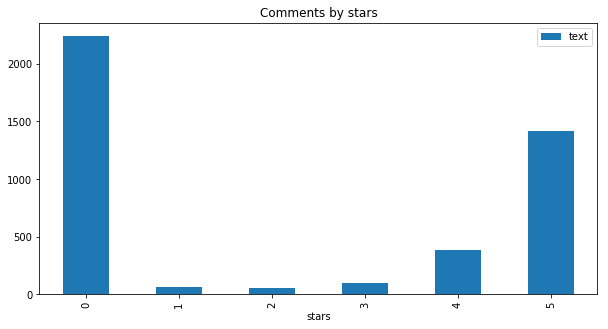

In [49]:
ua_comments_df.groupby(['stars']).agg({'text':'count'}).\
plot.bar(title = "Comments by stars", figsize=(10,5))